In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import config
from Dataset import FrameInterpolationDataset
from Generator import Generator
from Discriminator import Discriminator
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import generate_images
import numpy as np
import cv2


In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,epoch
):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * config.L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                G_loss=G_loss.item(),
                D_loss=D_loss.item(),
                epoch=epoch
            )

In [4]:
def test_fn(disc, gen, loader, l1_loss, bce):
    loop = tqdm(loader, leave=True)

    disc_losses = []
    gen_losses = []
    for idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        # test Discriminator
        with torch.no_grad():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake)
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2
            disc_losses.append(D_loss.cpu().numpy())

        # test generator
        with torch.no_grad():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * config.L1_LAMBDA
            G_loss = G_fake_loss + L1
            gen_losses.append(G_loss.cpu().numpy())
    return np.array(gen_losses).mean(),np.array(disc_losses).mean()

In [5]:
disc = Discriminator(input_channels=3,features=64).to(config.DEVICE)
gen = Generator(input_channels=6,output_channels=3, features=64).to(config.DEVICE)

gen.load_state_dict(torch.load('gen.pt'))
disc.load_state_dict(torch.load('disc.pt'))

<All keys matched successfully>

100%|██████████| 170/170 [03:13<00:00,  1.14s/it, D_loss=0.693, G_loss=3.24, epoch=0]


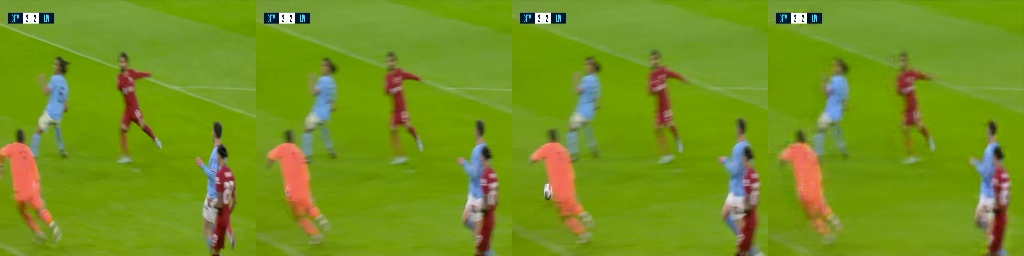

In [7]:
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(00, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()


train_dataset = FrameInterpolationDataset(img_paths=config.TRAIN_DIR)
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
)

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

best_test_loss_disc = float('inf')
best_test_loss_gen = float('inf')

for epoch in range(config.NUM_EPOCHS):
    train_fn(
        disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,epoch
    )
    
    generate_images(gen, "dataset/train/2862.jpg")
    # torch.save(disc.state_dict(), config.CHECKPOINT_DISC)
    # torch.save(gen.state_dict(), config.CHECKPOINT_GEN)


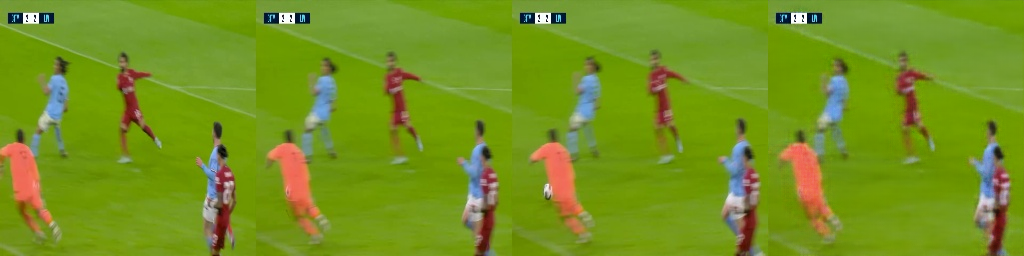

In [6]:
generate_images(gen, "dataset/train/2862.jpg")